# Title: Predicting the experience of a Minecraft player by using age and hours played through kNN-classification algorithm

- Names: Eva Yarantseva, Ivan Chau, Rihanna Xu, Heidi Zhu
- Student Numbers: 32172173, 53215745, 61625810, 80627912
- Section: 009-30

## Introduction

<p>Minecraft is an sandbox video game developed by Mojang Studios that places players in a 3D world composed of pixelated blocks. The game contains no specific goals to accomplish, giving the players to freedom to choose how they want to play. </p>

<p>A research group at the University of British Columbia Department of Computer Science, seeks to develop an advanced AI model that is capable of processing, acting, and learning from real world settings, similar to humans. To train their AI model, the group utilizes a dedicated Minecraft server called "Plaicraft" to collect data of human gameplay. We will be utilizing the data collected by the research group to observe relationships between player characteristics. </p>

Broad Question: 
- We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific Question:
- Can a player's age and playtime predict the player's level of experience?

We are using the players data set obtained by the research group. Information about the player is collected through signing up for PlaiCraft with their email address. Once a player has joined the multiplayer PlaiCraft server, a record of the player's gameplay, speech, and key presses on the Minecraft browser are logged. 

The players data set has a total of 196 observations and 7 variables. The description of the data set is as follows:
|Variable|Data Type|Definition|
|--------|---------|----------|
|experience|Character|experience level of player|
|subscribe|Boolean|whether or not the player has subscribed to the newsletter|
|hashedEmail|Character|encrypted email address|
|played_hours|Double|Total hours played|
|name|Character|Name of player|
|gender|Character|Gender of player|
|Age|Double|Age of player in years|

<p>In this project, we have chosen two variables to predict the level of experience of the player</p>

Reponse Variable
- experience

Explantory Variable
- player_hours
- Age

## Methods and Results

### Importing Libraries

In [2]:
# loading all of the necessary packages for plotting, predicting:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading the data (players.csv)

The dataset used in this analysis will be "players.csv". 

In [3]:
# Loading data via absolute pathway
players <- read_csv("https://raw.githubusercontent.com/evayarantseva/dsci-100-2025w1-group-30/main/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling and tidying the data for analysis

While analyzing the data set inside an editor, we noticed that there are NA inputs. These NA values will cause problems when trying to compute summary statistics.

In [4]:
# Discarding NA values inside the Data set

players <- players |> drop_na()


Our analysis involves using two numerical variables as the predictors, and one categorical as the response. Since we are predicting the experience of the player, we convert the "experience" variable from a character to a factor.

In [5]:
# Tidying the data

# Converting the gender variable into a factor
players <- players |>
    mutate(experience = as.factor(experience))

### Summary of Statistics of Numerical Variables

In [9]:
players_summary_data<-players |> 
  summarise(
    mean_age = round(mean(Age, na.rm = TRUE), 2),
    median_age = round(median(Age, na.rm = TRUE), 2),
    sd_age = round(sd(Age, na.rm = TRUE), 2),
    mean_hours = round(mean(played_hours, na.rm = TRUE), 2),
    median_hours = round(median(played_hours, na.rm = TRUE), 2),
    sd_hours = round(sd(played_hours, na.rm = TRUE), 2))
players_summary_data


mean_age,median_age,sd_age,mean_hours,median_hours,sd_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,7.39,5.9,0.1,28.5


### Visualization of the Data

A KNN-classification algorithm relies on multiple predictors to classify a new observation via straight-line distance between K nearest neighbours. First, we will look at the relationship between the two numeric variables in players.csv (Age and played_hours) to see if the data is suitable for KNN-classification (see: Plot 1).

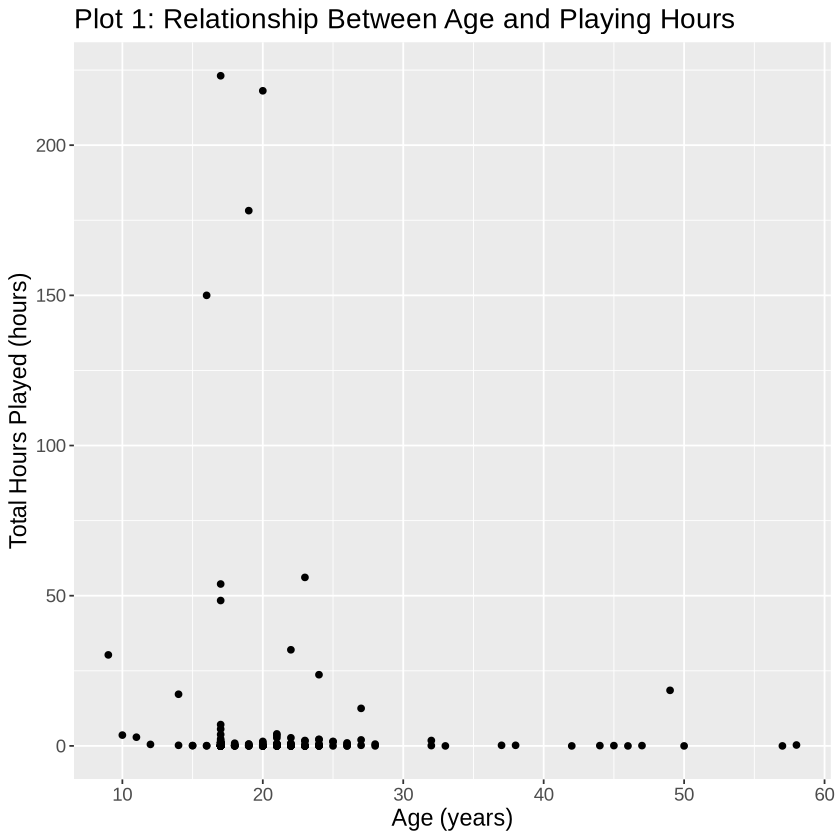

In [7]:
# Visualizing the relationship between age and hours played

ggplot(data = players, aes(x = Age, y = played_hours)) +
    geom_point() +
    labs(
        title = "Plot 1: Relationship Between Age and Playing Hours",
        x = "Age (years)",
        y = "Total Hours Played (hours)",
        ) + 
    theme(text = element_text(size = 14))

Plot 1: the data is concentrated bottom left corner (between ages 10-30, and 0-50 hours). The four outliers that have a range of 150-225 hours played are between 15-20 years old. The players that are older than 30 have less than 25 hours played in the server.

There is an unbalance in data: the K-NN model may have trouble making predictions due to the lack of data on the top right hand side of the plot (people who are older than 30 and play more than 25 hours).

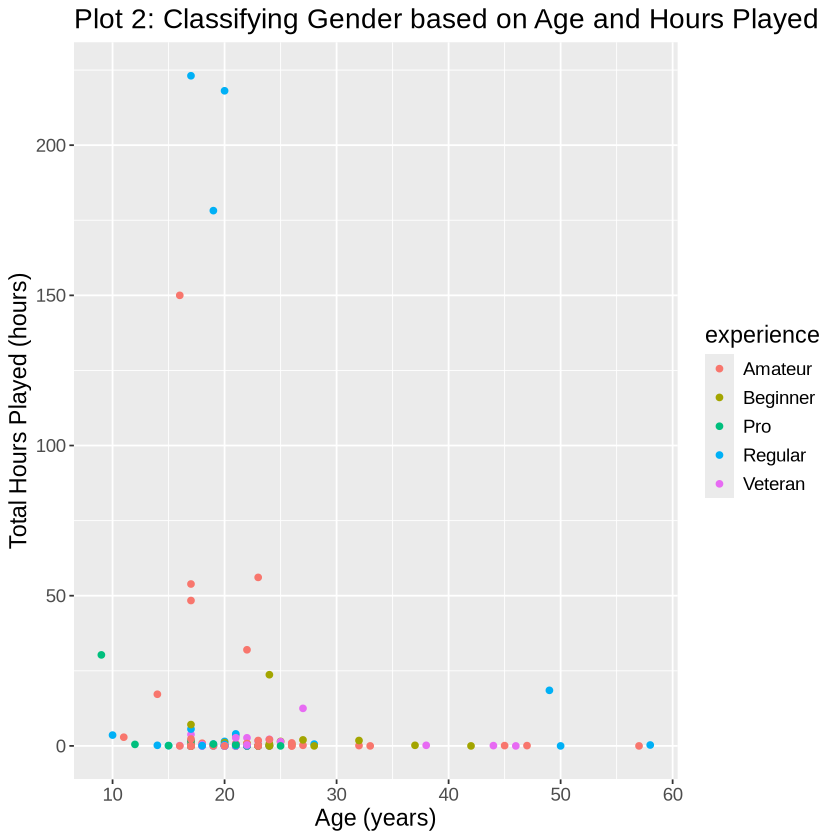

In [6]:
# Seeing if there are clustsers points that indicate experience:

ggplot(data = players, aes(x = Age, y = played_hours, color = experience)) +
    geom_point() +
    labs(
        title = "Plot 2: Classifying Gender based on Age and Hours Played",
        x = "Age (years)",
        y = "Total Hours Played (hours)",
        ) + 
    theme(text = element_text(size = 14)) + 
    scale_fill_brewer(palette = "Set1")

Plot 2: shows the distribution of experience level accross the scatterplot, when plotting age against weekly playing hours. The imbalance in data will make it hard to predict experience level for people who are over the age of 30-40 and play more than 25 hours a week. However, the distribution of experience seems to be fairily equal towards the bottom left corner where there is a larger concentration of data.

### Data Analysis 

The dataset will be split into training (75%, which will be used to train the model) and testing (25%, to measure accruracy of the model) to see if the model is able to accurately classify new observations. A seed will be used to ensure reproducability of results:

In [7]:
# Split into training and testing data

set.seed(3456) 
players_split <- initial_split(players, prop = 0.75, strata = experience)  
players_train <- training(players_split)   
players_test <- testing(players_split)

As seen in Plot 1 and Plot 2, the range of weekly hours played is significantly larger than that of age. Therefore, the predictors will be scaled in a recipe to ensure they are both contributing equally to the classification of new observations:

In [8]:
# Pre-process the variables by scaling them in a recipe
set.seed(3456)
players_recipe <- recipe(experience ~ Age + played_hours , data = players_train) |>
   step_center(all_predictors()) |>
   step_scale(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



The parameter that needs be determined to optimize the predictive ability of the KNN model is K, the number of neighbours. To find the K number of neighbours, we specify a classification model (i.e. predicts a categorical variable) that weighs both predictors equally (i.e. rectangular), and set the number of neighbours to tune() which informs tidymodel that this is the parameter that is going to be found.

In [9]:
# Specifcy model with tuning on the number of neighbours
set.seed(3456)
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

To test the accuracy of the model using different values of K, the training set will be further split up into v number of "folds" using v-fold cross validation. Each fold will be used as validation once, and as training for the rest. The strata argument will ensure the same proportions of the categories in each training and validation set. The v is set to 5 below:

In [10]:
# Perform a 5-fold cross validation on the training set
set.seed(3456)

fold <- vfold_cv(players_train, v=5, strata = experience)

To find the accuracy for each value of k specifided in the tibble below, we create a workflow for the data analysis. This will allow us to run cross-validation on the training and validation split. The average accuracy of estimate from each validation will be use to determine K. In our model, we will be testing K values ranging from 2 to 15. 

In [11]:
# Create the workflow analysis to tune the K parameter

k_vals <- tibble(neighbors = seq(from = 2, to = 15, by = 1))

results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = fold, grid = k_vals) |>
      collect_metrics()

accuracies <- results |>
            filter(.metric == "accuracy")

→ A | warning: ✖ No observations were detected in `truth` for level: Pro.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





To find K with the highest accuracy we plot the relationship between the two:

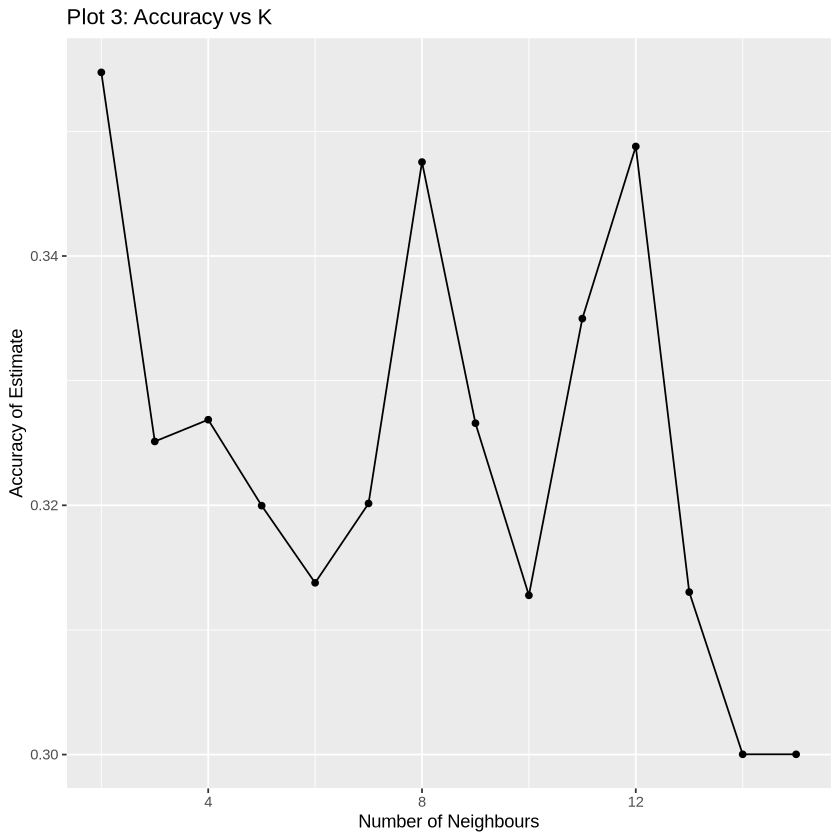

In [12]:
# Plotting the results to find K

cross_val_plot <- accuracies |>
                ggplot(aes(x=neighbors, y=mean)) +
                geom_point() + geom_line() +
                labs(x = "Number of Neighbours", y= "Accuracy of Estimate") +
                ggtitle("Plot 3: Accuracy vs K")
cross_val_plot

Plot 3: there is the highest peak in accuracy when K = 2 (at accuracy ~ 0.355). We will use K = 2 as our optimized parameter to test our classification model. 

Now that we have chosen K = 2, we define our final model and fit our data onto it in a workflow:

In [26]:
# Fitting the final model

players_spec <- nearest_neighbor(weight_func="rectangular", neighbors=2) |>
            set_engine("kknn") |>
            set_mode("classification")

players_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_spec) |>
          fit(data = players_train)

To see if how our model performed, we test our model using the testing portion of the dataset (players_test), and quantify the predictive ability of the model by finding the accuracy. We can also see how myc

In [27]:
# Testing the model on the dataset

players_predictions <- predict(players_fit, players_test) |>
                    bind_cols(players_test)

players_metrics <- players_predictions |>
                metrics(truth = experience, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                conf_mat(truth = experience, estimate = .pred_class)


players_metrics
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.1200000
kap,multiclass,-0.1591149


          Truth
Prediction Amateur Beginner Pro Regular Veteran
  Amateur        4        5   3       3       6
  Beginner       3        1   0       4       2
  Pro            0        1   0       0       0
  Regular        4        1   1       1       4
  Veteran        4        2   0       1       0

### Visualization of Analysis

## Discussion

    Interpretation of the model result:

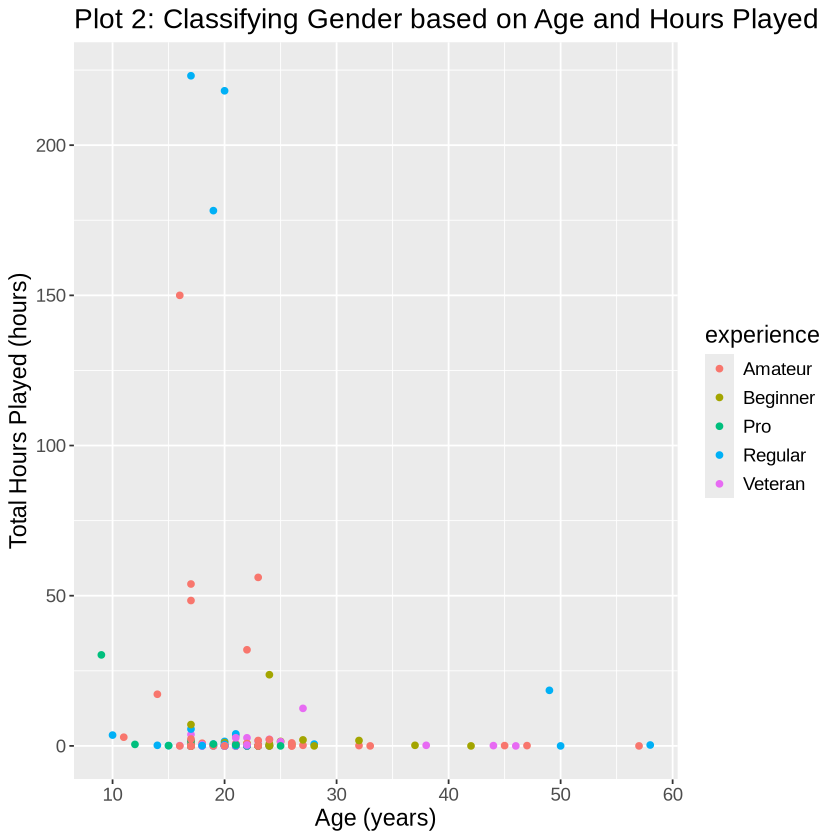

In [21]:
ggplot(data = players, aes(x = Age, y = played_hours, color = experience)) +
    geom_point() +
    labs(
        title = "Plot 2: Classifying Gender based on Age and Hours Played",
        x = "Age (years)",
        y = "Total Hours Played (hours)",
        ) + 
    theme(text = element_text(size = 14)) + 
    scale_fill_brewer(palette = "Set1")

Plot 2 shows the distribution of experience level between the two predictors and Hours. Unlike the methods part, where we want to test whether kNN was a proper choice. This diagram illustrates the reason why our model exhibits low accuracy, resulting in a negative kappa value. The plot reveals obvious and substantial overlap among all five experience levels, indicating there is no clear separation of clusters based on these predictors. Therefore. It fails to train the model to accurately classify observations.

    Limitations:
    1. Age and hours played do not distinguish the experience groups well. Most data points cluster tightly in the bottom-left area, and players with low experience can still have high playtime, while some skilled players show low hours on this server.
    
    2. A small number of players with extremely high playtime values (150–225 hours) skew the distance calculations, reducing the reliability of the kNN model.

    3. The response variable (levels of experience) has too many categories. Each class ends up with relatively few observations. With fewer data points per group, the nearest neighbors selected by the algorithm are less likely to belong to the correct class, which makes it difficult for kNN to learn meaningful class boundaries.
    

    Further Improvement:
    1. Address extreme outliers
    
    2. Because the experience variable has many categories with small sample sizes, similar experience levels could be combined into broader groups to ensure more balanced classes.
    
    3. Since age and total hours played do not meaningfully distinguish experience levels, future analyses should include more variables.
    
    4. Subscribing to the game-related newsletter may serve as a better response variable because it has only two categories (“TRUE” or “FALSE”), making it a binary classification problem. Binary outcomes are generally easier for kNN and other models to predict, especially when the dataset is small or imbalanced.
    

## References

- PLAICraft FAQ Pahttps://plaicraft.ai/faq/general 
- Landin, P. (2023). *What is Minecraft?.* Minecraft. https://www.minecraft.net/en-us/article/what-minecraft